# Python文本分析
#### 安装相关库

In [ ]:
!pip install jieba
!pip install wordcloud

## 制作词云

#### 导入`jieba`分词模块：

In [106]:
import jieba

#### 体验一下分词：

In [107]:
s = "结婚的和尚未结婚的"

In [110]:
list(jieba.cut(s))

['结婚', '的', '和', '尚未', '结婚', '的']

#### 导入文本文件，读入一个字符串，并进行分词：

In [116]:
with open('test.txt') as f:
    s = f.read()
cut_s = list(jieba.cut(s))

#### 初始化`wordcloud`模块：

In [117]:
import wordcloud
wc = wordcloud.WordCloud(background_color = "white", font_path = "TW-Kai-98_1.ttf")

#### 将分词重新拼接为一个字符串，绘制词云：

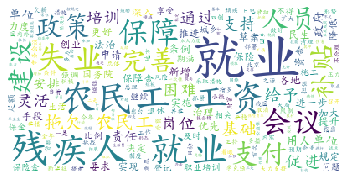

In [118]:
%matplotlib inline
import matplotlib.pyplot as plt
myword = wc.generate(' '.join(cut_s))
plt.imshow(myword)
plt.axis("off")
plt.show()

## 基于情感词典的情感分析

#### 导入停用词表

In [119]:
with open('stopwords.txt',encoding='utf-8') as f:
    stopwords = f.read().split('\n')
stopwords

[',',
 '?',
 '、',
 '。',
 '“',
 '”',
 '《',
 '》',
 '！',
 '，',
 '：',
 '；',
 '？',
 '人民',
 '末##末',
 '啊',
 '阿',
 '哎',
 '哎呀',
 '哎哟',
 '唉',
 '俺',
 '俺们',
 '按',
 '按照',
 '吧',
 '吧哒',
 '把',
 '罢了',
 '被',
 '本',
 '本着',
 '比',
 '比方',
 '比如',
 '鄙人',
 '彼',
 '彼此',
 '边',
 '别',
 '别的',
 '别说',
 '并',
 '并且',
 '不比',
 '不成',
 '不单',
 '不但',
 '不独',
 '不管',
 '不光',
 '不过',
 '不仅',
 '不拘',
 '不论',
 '不怕',
 '不然',
 '不如',
 '不特',
 '不惟',
 '不问',
 '不只',
 '朝',
 '朝着',
 '趁',
 '趁着',
 '乘',
 '冲',
 '除',
 '除此之外',
 '除非',
 '除了',
 '此',
 '此间',
 '此外',
 '从',
 '从而',
 '打',
 '待',
 '但',
 '但是',
 '当',
 '当着',
 '到',
 '得',
 '的',
 '的话',
 '等',
 '等等',
 '地',
 '第',
 '叮咚',
 '对',
 '对于',
 '多',
 '多少',
 '而',
 '而况',
 '而且',
 '而是',
 '而外',
 '而言',
 '而已',
 '尔后',
 '反过来',
 '反过来说',
 '反之',
 '非但',
 '非徒',
 '否则',
 '嘎',
 '嘎登',
 '该',
 '赶',
 '个',
 '各',
 '各个',
 '各位',
 '各种',
 '各自',
 '给',
 '根据',
 '跟',
 '故',
 '故此',
 '固然',
 '关于',
 '管',
 '归',
 '果然',
 '果真',
 '过',
 '哈',
 '哈哈',
 '呵',
 '和',
 '何',
 '何处',
 '何况',
 '何时',
 '嘿',
 '哼',
 '哼唷',
 '呼哧',
 '乎',
 '哗',
 '还是',
 '还有',
 '换句话说',
 '换言之',
 '或',
 

#### 导入情感词汇

In [120]:
with open('BosonNLP_sentiment_score.txt',encoding='utf-8') as f:
    kv = [line.split() for line in f ]
kv

[['最尼玛', '-6.70400012637'],
 ['扰民', '-6.49756445867'],
 ['fuck...', '-6.32963390433'],
 ['RNM', '-6.21861284426'],
 ['wcnmlgb', '-5.96710044003'],
 ['2.5:', '-5.90459648251'],
 ['Fxxk', '-5.87247473641'],
 ['MLP', '-5.87247473641'],
 ['吃哑巴亏', '-5.77120419579'],
 ['IAQI', '-5.77107837123'],
 ['MLGBD', '-5.69408191501'],
 ['NNND', '-5.66228462641'],
 ['MLGB.', '-5.60457743583'],
 ['成甘', '-5.60457743583'],
 ['最桑', '-5.60457743583'],
 ['真无语', '-5.60457743583'],
 ['ＴＭ', '-5.60457743583'],
 ['次奥次奥次奥', '-5.59258287133'],
 ['cnmd', '-5.54446545761'],
 ['MBD', '-5.50280109843'],
 ['NNDX', '-5.48173951768'],
 ['水蛭', '-5.48173951768'],
 ['美素丽', '-5.48173951768'],
 ['草尼', '-5.48173951768'],
 ['凌迟', '-5.46005372985'],
 ['尼玛尼玛尼玛', '-5.42622557462'],
 ['冠周炎', '-5.41616190446'],
 ['加塞儿', '-5.41616190446'],
 ['日尼玛', '-5.41616190446'],
 ['朝仲', '-5.41616190446'],
 ['MD...', '-5.34746092937'],
 ['shit....', '-5.34746092937'],
 ['人清', '-5.34746092937'],
 ['风疹块', '-5.34746092937'],
 ['ＴＭＤ', '-5.34746092937'

In [124]:
sendict = {k:float(v) for (k,v) in kv}
sendict['不翼而飞']

-3.60671385172

#### 导入否定词汇

In [125]:
with open("deny.txt",encoding="utf-8") as f:
    denywords = f.read().split("\n")
denywords

['不',
 '非',
 '别',
 '甭',
 '不必',
 '不曾',
 '不要',
 '没',
 '没有',
 '莫',
 '不用',
 '何必',
 '何须',
 '何曾',
 '何尝',
 '空',
 '白',
 '干',
 '徒',
 '徒然',
 '无能',
 '未',
 '未曾',
 '未尝',
 '无需',
 '毋庸',
 '勿',
 '否']

#### 导入程度副词

In [127]:
with open('level_adv.txt',encoding='gbk') as f:
    level = f.read().split('\n')
level

['中文程度级别词语\t\t219',
 '',
 '1. “极其|extreme / 最|most”\t69',
 '百分之百',
 '倍加',
 '备至',
 '不得了',
 '不堪',
 '不可开交',
 '不亦乐乎',
 '不折不扣',
 '彻头彻尾',
 '充分',
 '到头',
 '地地道道',
 '非常',
 '极',
 '极度',
 '极端',
 '极其',
 '极为',
 '截然',
 '尽',
 '惊人地',
 '绝',
 '绝顶',
 '绝对',
 '绝对化',
 '刻骨',
 '酷',
 '满',
 '满贯',
 '满心',
 '莫大',
 '奇',
 '入骨',
 '甚为',
 '十二分',
 '十分',
 '十足',
 '死',
 '滔天',
 '痛',
 '透',
 '完全',
 '完完全全',
 '万',
 '万般',
 '万分',
 '万万',
 '无比',
 '无度',
 '无可估量',
 '无以复加',
 '无以伦比',
 '要命',
 '要死',
 '已极',
 '已甚',
 '异常',
 '逾常',
 '贼',
 '之极',
 '之至',
 '至极',
 '卓绝',
 '最为',
 '佼佼',
 '郅',
 '綦',
 '齁',
 '最',
 '',
 '2. “很|very”\t42',
 '不过',
 '不少',
 '不胜',
 '惨',
 '沉',
 '沉沉',
 '出奇',
 '大为',
 '多',
 '多多',
 '多加',
 '多么',
 '分外',
 '格外',
 '够瞧的',
 '够戗',
 '好',
 '好不',
 '何等',
 '很',
 '很是',
 '坏',
 '可',
 '老',
 '老大',
 '良',
 '颇',
 '颇为',
 '甚',
 '实在',
 '太',
 '太甚',
 '特',
 '特别',
 '尤',
 '尤其',
 '尤为',
 '尤以',
 '远',
 '着实',
 '曷',
 '碜',
 '',
 '3. “较|more”\t37',
 '大不了',
 '多',
 '更',
 '更加',
 '更进一步',
 '更为',
 '还',
 '还要',
 '较',
 '较比',
 '较为',
 '进一步',
 '那般',
 '那么',
 '那样',
 '强',
 '如斯',
 '益'

In [89]:
for i,w in enumerate(level):
    print(i,w)

0 中文程度级别词语		219
1 
2 1. “极其|extreme / 最|most”	69
3 百分之百
4 倍加
5 备至
6 不得了
7 不堪
8 不可开交
9 不亦乐乎
10 不折不扣
11 彻头彻尾
12 充分
13 到头
14 地地道道
15 非常
16 极
17 极度
18 极端
19 极其
20 极为
21 截然
22 尽
23 惊人地
24 绝
25 绝顶
26 绝对
27 绝对化
28 刻骨
29 酷
30 满
31 满贯
32 满心
33 莫大
34 奇
35 入骨
36 甚为
37 十二分
38 十分
39 十足
40 死
41 滔天
42 痛
43 透
44 完全
45 完完全全
46 万
47 万般
48 万分
49 万万
50 无比
51 无度
52 无可估量
53 无以复加
54 无以伦比
55 要命
56 要死
57 已极
58 已甚
59 异常
60 逾常
61 贼
62 之极
63 之至
64 至极
65 卓绝
66 最为
67 佼佼
68 郅
69 綦
70 齁
71 最
72 
73 2. “很|very”	42
74 不过
75 不少
76 不胜
77 惨
78 沉
79 沉沉
80 出奇
81 大为
82 多
83 多多
84 多加
85 多么
86 分外
87 格外
88 够瞧的
89 够戗
90 好
91 好不
92 何等
93 很
94 很是
95 坏
96 可
97 老
98 老大
99 良
100 颇
101 颇为
102 甚
103 实在
104 太
105 太甚
106 特
107 特别
108 尤
109 尤其
110 尤为
111 尤以
112 远
113 着实
114 曷
115 碜
116 
117 3. “较|more”	37
118 大不了
119 多
120 更
121 更加
122 更进一步
123 更为
124 还
125 还要
126 较
127 较比
128 较为
129 进一步
130 那般
131 那么
132 那样
133 强
134 如斯
135 益
136 益发
137 尤甚
138 逾
139 愈
140 愈 ... 愈
141 愈发
142 愈加
143 愈来愈
144 愈益
145 远远
146 越 ... 越
147 越发
148 越加
149 越来越
150 越

#### 按程度分为6组

In [90]:
level1 = level[188:200]

In [91]:
level2 = level[157:186]

In [92]:
level3 = level[202:232]

In [93]:
level4 = level[118:155]

In [94]:
level5 = level[74:116]

In [95]:
level6 = level[3:72]

#### 按程度赋予得分

In [97]:
levels = [(level1,0.5),(level2,0.8),(level3,1.1),(level4,1.3),(level5,1.6),(level6,2)]
levels

[(['半点', '不大', '不丁点儿', '不甚', '不怎么', '聊', '没怎么', '轻度', '弱', '丝毫', '微', '相对'],
  0.5),
 (['点点滴滴',
   '多多少少',
   '怪',
   '好生',
   '还',
   '或多或少',
   '略',
   '略加',
   '略略',
   '略微',
   '略为',
   '蛮',
   '稍',
   '稍稍',
   '稍微',
   '稍为',
   '稍许',
   '挺',
   '未免',
   '相当',
   '些',
   '些微',
   '些小',
   '一点',
   '一点儿',
   '一些',
   '有点',
   '有点儿',
   '有些'],
  0.8),
 (['不为过',
   '超',
   '超额',
   '超外差',
   '超微结构',
   '超物质',
   '出头',
   '多',
   '浮',
   '过',
   '过度',
   '过分',
   '过火',
   '过劲',
   '过了头',
   '过猛',
   '过热',
   '过甚',
   '过头',
   '过于',
   '过逾',
   '何止',
   '何啻',
   '开外',
   '苦',
   '老',
   '偏',
   '强',
   '溢',
   '忒'],
  1.1),
 (['大不了',
   '多',
   '更',
   '更加',
   '更进一步',
   '更为',
   '还',
   '还要',
   '较',
   '较比',
   '较为',
   '进一步',
   '那般',
   '那么',
   '那样',
   '强',
   '如斯',
   '益',
   '益发',
   '尤甚',
   '逾',
   '愈',
   '愈 ... 愈',
   '愈发',
   '愈加',
   '愈来愈',
   '愈益',
   '远远',
   '越 ... 越',
   '越发',
   '越加',
   '越来越',
   '越是',
   '这般',
   '这样',
   '足',
   '足足'],
  1.3),
 (['不过',
   '不少',
  

#### 构造程度词字典

In [130]:
from functools import reduce

In [136]:
k,v = levels[0]

In [137]:
k

['半点', '不大', '不丁点儿', '不甚', '不怎么', '聊', '没怎么', '轻度', '弱', '丝毫', '微', '相对']

In [138]:
v

0.5

In [139]:
list(map(lambda x:(x,v),k))

[('半点', 0.5),
 ('不大', 0.5),
 ('不丁点儿', 0.5),
 ('不甚', 0.5),
 ('不怎么', 0.5),
 ('聊', 0.5),
 ('没怎么', 0.5),
 ('轻度', 0.5),
 ('弱', 0.5),
 ('丝毫', 0.5),
 ('微', 0.5),
 ('相对', 0.5)]

In [104]:
levels_with_score = [list(map(lambda x:(x,v),k)) for k,v in levels]
levels_with_score

[[('半点', 0.5),
  ('不大', 0.5),
  ('不丁点儿', 0.5),
  ('不甚', 0.5),
  ('不怎么', 0.5),
  ('聊', 0.5),
  ('没怎么', 0.5),
  ('轻度', 0.5),
  ('弱', 0.5),
  ('丝毫', 0.5),
  ('微', 0.5),
  ('相对', 0.5)],
 [('点点滴滴', 0.8),
  ('多多少少', 0.8),
  ('怪', 0.8),
  ('好生', 0.8),
  ('还', 0.8),
  ('或多或少', 0.8),
  ('略', 0.8),
  ('略加', 0.8),
  ('略略', 0.8),
  ('略微', 0.8),
  ('略为', 0.8),
  ('蛮', 0.8),
  ('稍', 0.8),
  ('稍稍', 0.8),
  ('稍微', 0.8),
  ('稍为', 0.8),
  ('稍许', 0.8),
  ('挺', 0.8),
  ('未免', 0.8),
  ('相当', 0.8),
  ('些', 0.8),
  ('些微', 0.8),
  ('些小', 0.8),
  ('一点', 0.8),
  ('一点儿', 0.8),
  ('一些', 0.8),
  ('有点', 0.8),
  ('有点儿', 0.8),
  ('有些', 0.8)],
 [('不为过', 1.1),
  ('超', 1.1),
  ('超额', 1.1),
  ('超外差', 1.1),
  ('超微结构', 1.1),
  ('超物质', 1.1),
  ('出头', 1.1),
  ('多', 1.1),
  ('浮', 1.1),
  ('过', 1.1),
  ('过度', 1.1),
  ('过分', 1.1),
  ('过火', 1.1),
  ('过劲', 1.1),
  ('过了头', 1.1),
  ('过猛', 1.1),
  ('过热', 1.1),
  ('过甚', 1.1),
  ('过头', 1.1),
  ('过于', 1.1),
  ('过逾', 1.1),
  ('何止', 1.1),
  ('何啻', 1.1),
  ('开外', 1.1),
  ('苦', 1.1),
  ('老

In [101]:
leveldict= dict(reduce(lambda x,y:x+y,levels_with_score))
leveldict

{'半点': 0.5,
 '不大': 0.5,
 '不丁点儿': 0.5,
 '不甚': 0.5,
 '不怎么': 0.5,
 '聊': 0.5,
 '没怎么': 0.5,
 '轻度': 0.5,
 '弱': 0.5,
 '丝毫': 0.5,
 '微': 0.5,
 '相对': 0.5,
 '点点滴滴': 0.8,
 '多多少少': 0.8,
 '怪': 0.8,
 '好生': 0.8,
 '还': 1.3,
 '或多或少': 0.8,
 '略': 0.8,
 '略加': 0.8,
 '略略': 0.8,
 '略微': 0.8,
 '略为': 0.8,
 '蛮': 0.8,
 '稍': 0.8,
 '稍稍': 0.8,
 '稍微': 0.8,
 '稍为': 0.8,
 '稍许': 0.8,
 '挺': 0.8,
 '未免': 0.8,
 '相当': 0.8,
 '些': 0.8,
 '些微': 0.8,
 '些小': 0.8,
 '一点': 0.8,
 '一点儿': 0.8,
 '一些': 0.8,
 '有点': 0.8,
 '有点儿': 0.8,
 '有些': 0.8,
 '不为过': 1.1,
 '超': 1.1,
 '超额': 1.1,
 '超外差': 1.1,
 '超微结构': 1.1,
 '超物质': 1.1,
 '出头': 1.1,
 '多': 1.6,
 '浮': 1.1,
 '过': 1.1,
 '过度': 1.1,
 '过分': 1.1,
 '过火': 1.1,
 '过劲': 1.1,
 '过了头': 1.1,
 '过猛': 1.1,
 '过热': 1.1,
 '过甚': 1.1,
 '过头': 1.1,
 '过于': 1.1,
 '过逾': 1.1,
 '何止': 1.1,
 '何啻': 1.1,
 '开外': 1.1,
 '苦': 1.1,
 '老': 1.6,
 '偏': 1.1,
 '强': 1.3,
 '溢': 1.1,
 '忒': 1.1,
 '大不了': 1.3,
 '更': 1.3,
 '更加': 1.3,
 '更进一步': 1.3,
 '更为': 1.3,
 '还要': 1.3,
 '较': 1.3,
 '较比': 1.3,
 '较为': 1.3,
 '进一步': 1.3,
 '那般': 1.3,
 '那么': 1.3,
 '那样

#### 取得程度词和情感词的列表
现在已经有三个列表，分别是否定词、情感词和程度副词列表，可用于判断一个词是不是属于三种词之一。

In [140]:
levelwords = leveldict.keys()
senwords = sendict.keys()

In [141]:
'不胜' in levelwords

True

In [142]:
'不' in denywords

True

In [143]:
'晚餐' in senwords

True

#### 定义词性判断函数

In [144]:
def is_senword(word):
    return word in senwords

def is_denyword(word):
    return word in denywords

def is_levelword(word):
    return word in levelwords

#### 定义函数，将字符串分词，去除停用词，并构造情感词词组列表
情感词词组由（否定词+程度副词+情感词）组成。

In [153]:
def append_sen(l,y):
    l[-1].append(y)
  
    l.append([])

    return l

def append_other(l,y):

    l[-1].append(y)
 
    return l

In [146]:
def to_phrases(s):
    s = list(filter(lambda x : x not in stopwords,jieba.cut(s)))
    s = list(filter(lambda x:is_denyword(x) or is_levelword(x) or is_senword(x),s))
    return reduce(lambda x,y: append_other(x,y) if is_denyword(y) or is_levelword(y) else append_sen(x,y),s,[[]])[:-1]

In [ ]:
is_senword("完全")

In [147]:
to_phrases("非常好的酒店,服务也很好.我住的是行政豪华房,里面干净宽敞舒服,对面可以看到锦绣中华的全景,晚上还可以看到那里的烟花,好漂亮.还可以延长到下午的4:30之前退房.下次还会选择住这家酒店")

[[]]
[['好']]
[['好', '酒店']]
[['好', '酒店'], []]
[['好', '酒店'], ['服务']]
[['好', '酒店'], ['服务'], []]
[['好', '酒店'], ['服务'], []]
[['好', '酒店'], ['服务'], ['好']]
[['好', '酒店'], ['服务'], ['好', '住']]
[['好', '酒店'], ['服务'], ['好', '住'], []]
[['好', '酒店'], ['服务'], ['好', '住'], ['豪华']]
[['好', '酒店'], ['服务'], ['好', '住'], ['豪华'], []]
[['好', '酒店'], ['服务'], ['好', '住'], ['豪华'], ['房']]
[['好', '酒店'], ['服务'], ['好', '住'], ['豪华'], ['房'], []]
[['好', '酒店'], ['服务'], ['好', '住'], ['豪华'], ['房'], ['干净']]
[['好', '酒店'], ['服务'], ['好', '住'], ['豪华'], ['房'], ['干净'], []]
[['好', '酒店'], ['服务'], ['好', '住'], ['豪华'], ['房'], ['干净'], ['宽敞']]
[['好', '酒店'], ['服务'], ['好', '住'], ['豪华'], ['房'], ['干净'], ['宽敞'], []]
[['好', '酒店'], ['服务'], ['好', '住'], ['豪华'], ['房'], ['干净'], ['宽敞'], ['对面']]
[['好', '酒店'], ['服务'], ['好', '住'], ['豪华'], ['房'], ['干净'], ['宽敞'], ['对面'], []]
[['好', '酒店'], ['服务'], ['好', '住'], ['豪华'], ['房'], ['干净'], ['宽敞'], ['对面'], ['看到']]
[['好', '酒店'], ['服务'], ['好', '住'], ['豪华'], ['房'], ['干净'], ['宽敞'], ['对面'], ['看到'], []]
[['好', '酒店'], ['服务'], 

[['好', '酒店'],
 ['服务'],
 ['好', '住'],
 ['豪华'],
 ['房'],
 ['干净'],
 ['宽敞'],
 ['对面'],
 ['看到'],
 ['锦绣'],
 ['中华'],
 ['全景'],
 ['晚上'],
 ['看到'],
 ['烟花'],
 ['好', '漂亮'],
 ['延长'],
 ['下午'],
 ['30'],
 ['之前'],
 ['下次'],
 ['选择'],
 ['住'],
 ['这家'],
 ['酒店']]

#### 定义词组评分函数
为简单起见，我们定义情感评分为：$$(-1) ^ {|denywords|} * levelscore * senscore$$


In [148]:
def phrase_score(phrase):
    score_deny =(-1)**len(list(filter(is_denyword,phrase)))
    senw = filter(is_senword,phrase)
    score_sen = sum([sendict[s] for s in senw])
    levelw = filter(is_levelword,phrase)
    score_level = 1 if len(list(levelw))==0 else sum([leveldict[l] for l in levelw])
    return score_deny * score_level * score_sen

In [150]:
phrase_score([ '更换'])

0.826985932312

#### 定义评价句子的函数

In [151]:
import numpy as np
def sentence_score(sentence):
    phrases = to_phrases(sentence)
    return np.mean([phrase_score(p) for p in phrases]) if len(phrases)>0 else 0

In [154]:
sentence_score("宾馆虽然比较老，房间感觉还可以，服务很好，早餐品种少了点。打车起步价到海边。走路15分钟到好又多超市。在开发区里面出差住在这里很方便。")

0.09590612523912354

In [155]:
sentence_score("地理位置还不错，到哪里都比较方便，但是服务不象是豪生集团管理的，比较差。下午睡了一觉并洗了一个澡，本来想让酒店再来打扫一下，所以，打开了，请打扫的服务灯，可是到晚上回酒店，发现打扫得服务灯被关掉了，而房间还是没有打扫过。")

0.057630459234794124

### 读取语料库，测试正确率

#### 定义函数读取文件，去除空格和换行，得到待评价字符串。

In [156]:
def file2string(file):
    with open(file,encoding='gbk',errors='ignore') as f:
        s = f.read().replace(" ","").replace("\n","")
    return s

In [160]:
file2string("neg/neg.999.txt")

'说实在的我很失望，之前看了其他人的点评后觉得还可以才去的，结果让我们大跌眼镜。我想这家酒店以后无论如何我都不会再去了。'

#### 取得所有正负文本的路径

In [161]:
import os

In [163]:
pos = [os.path.join("pos",p) for p in os.listdir("pos")]
pos

['pos/pos.2545.txt',
 'pos/pos.861.txt',
 'pos/pos.1350.txt',
 'pos/pos.1282.txt',
 'pos/pos.849.txt',
 'pos/pos.796.txt',
 'pos/pos.1040.txt',
 'pos/pos.2462.txt',
 'pos/pos.2149.txt',
 'pos/pos.2528.txt',
 'pos/pos.275.txt',
 'pos/pos.431.txt',
 'pos/pos.757.txt',
 'pos/pos.2384.txt',
 'pos/pos.908.txt',
 'pos/pos.484.txt',
 'pos/pos.1807.txt',
 'pos/pos.2513.txt',
 'pos/pos.88.txt',
 'pos/pos.2283.txt',
 'pos/pos.267.txt',
 'pos/pos.898.txt',
 'pos/pos.1956.txt',
 'pos/pos.1752.txt',
 'pos/pos.145.txt',
 'pos/pos.779.txt',
 'pos/pos.321.txt',
 'pos/pos.1173.txt',
 'pos/pos.2091.txt',
 'pos/pos.338.txt',
 'pos/pos.2184.txt',
 'pos/pos.1976.txt',
 'pos/pos.2026.txt',
 'pos/pos.1497.txt',
 'pos/pos.2251.txt',
 'pos/pos.768.txt',
 'pos/pos.1367.txt',
 'pos/pos.2004.txt',
 'pos/pos.2465.txt',
 'pos/pos.2133.txt',
 'pos/pos.359.txt',
 'pos/pos.985.txt',
 'pos/pos.1580.txt',
 'pos/pos.2442.txt',
 'pos/pos.1115.txt',
 'pos/pos.1273.txt',
 'pos/pos.1054.txt',
 'pos/pos.1691.txt',
 'pos/pos.8

In [164]:
neg = [os.path.join("neg",p) for p in os.listdir("neg")]

#### 正向情感文本的得分情况

In [166]:
pos_sentences = [file2string(f) for f in pos]
pos_sentences

['性价比非常高的一家四星酒店。尤其是山东大汉服务生，服务非常好。自主餐很好，向您极力推荐。青岛的星级酒店很正规，比起其他的旅游城市，青岛整个环境很好，城市清洁，出租车司机都很好，不愧山东人本色。',
 '设施不新,房间大小适中,都是侧看海景,有无烟层.早餐比较普通,选择不多.',
 '地理位置不错,服务还可以吧,希望携程的房价以后更有竞争力一点',
 '饭店有些旧但房间干净,住高层向北房间安静,假如下次再去大同会再住.',
 '香港的酒店在面積方面就不需要強求什麼了﹗這家酒店設施已經比較陳舊了，不過交通比較方便的﹗服務方面尚可﹗',
 '据说这是北海最好的三星级酒店，生意不是一般的好，人气很旺，那天晚上到的时候大堂气氛浓烈，感觉很温馨。房间的卫生间小了点，不过服务好，心里就舒畅了。我住的房间还送早餐、果篮、晚上还有巧克力，最绝的是楼层服务员告诉我网络客人还可以免费烫衣服……哇。晚上大堂副理还电话拜访我，我告诉她电视调不好，她还亲自上来帮我调。总体感觉不错，大堂副理请我帮忙宣传一下，我同意了哈哈。',
 '入住的时候，恰逢前台的POS机坏了，只能预付现金，有些不便。不过位于一楼的餐厅真是物美价廉，值得一去。',
 '就在长途汽车站附近，步行10分钟吧。就是马路路口斜对过。在闹市区，路口有欧什么的西餐便餐店，环境不错。宾馆就是标准的4星，挺好的。附近还有kfc和农工商超市。',
 '入住酒店时把我自己行李丢在了出租车上，酒店的前厅部人员很热情，很积极帮我寻找，我很感动。酒店的总体感觉不错，舒适，安全，退房时候感觉两个总台人员不停的在忙碌，动作挺熟练，迅速的。',
 '应该算是仪征最好的酒店了，四星的设施，三星的服务。遗憾的是某些设施还并未开放。早餐很一般，连收盘子的服务员也没有，与其四星的标准不符。',
 '地理位置较好，在西街的街头处，购物游览交通都较方便，闹中取静，房间内设施也还可以，虽然离城市中的四星有些差距，但是在阳朔应该是最好的酒店了。但是心中还是有一些不舒服的地方，因在携程上订房时忘记写订大床间，登记入住时给的双人间，要求前台给予处理时，给到的答复是没有房间，但实际上还是有房间的。因此希望酒店在为客户着想的理念上需要再改善。当地的导游很好客，也很朴实，带我们去的月亮山脚下的“步高门”吃的中午饭，即实惠又好吃，赞。可惜在遇龙河漂流时照的照片遗失了。总的来说，

In [ ]:
import numpy as np

In [167]:
np.mean([sentence_score(s) for s in pos_sentences ])

0.46955396885923895

#### 负向情感文本的得分情况

In [168]:
neg_sentences = [file2string(f) for f in neg]

In [169]:
np.mean([sentence_score(s) for s in neg_sentences])

0.049814096452580246

#### 比较正向文本与负向文本的得分分布

In [170]:
import seaborn as sns

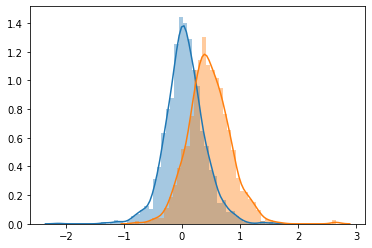

In [171]:
sns.distplot([sentence_score(s) for s in neg_sentences])
sns.distplot([sentence_score(s) for s in pos_sentences])